In [36]:
# Copyright 2018, JinYoung Kim Softcomputing LAB all rights reserved.
%matplotlib inline
from keras.models import *
from keras.layers import *
from keras.datasets import *
from keras.utils import *
from keras.callbacks import *
from keras import backend as K

from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm *= 1000
        cm = np.round(cm)
        cm /= 1000
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Load data

## Download MNIST dataset

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


## Visualization

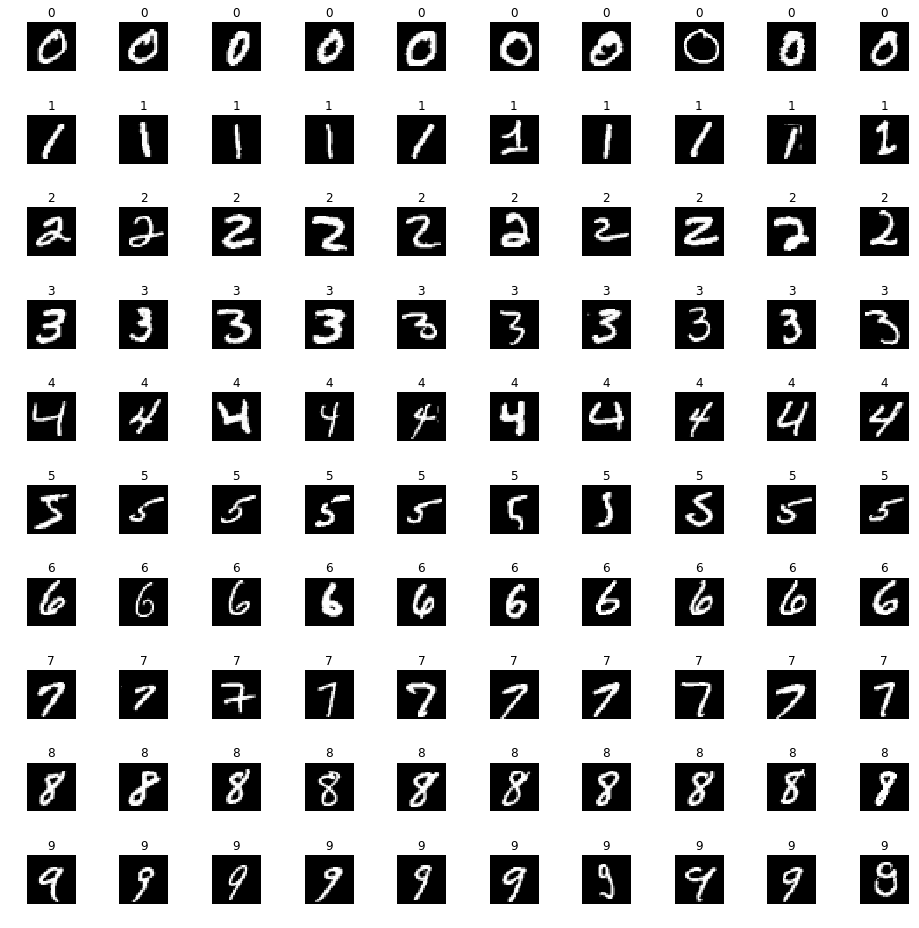

In [4]:
plt.figure(figsize=(13,13))
for i in range(np_utils.to_categorical(Y_train).shape[1]):
    for j in range(10):
        plt.subplot(10, np_utils.to_categorical(Y_train).shape[1], i * 10 + j + 1)
        plt.imshow(X_train[Y_train==i][j], cmap='gray')
        plt.axis('off')
        plt.title(str(i))
plt.tight_layout()
plt.show()

## Pre-processing data

In [5]:
X_train, X_test = X_train / (2. / 255.) - 1, X_test / (2. / 255.) - 1
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
Y_train, Y_test = np_utils.to_categorical(Y_train), np_utils.to_categorical(Y_test)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(60000, 28, 28, 1) (60000, 10)
(10000, 28, 28, 1) (10000, 10)


# Build Basic NN

In [27]:
def Basic_NN(hidden_units, n_class, activation='tanh', dropout = False, dropout_rate = -1, batchnormalization = False):
    if dropout and dropout_rate < 0:
        print('If you use dropout, specify dropout rate between 0 and 1')
        return -1
    def _f(inp):
        x = inp
        for i in range(len(hidden_units)):
            x = Dense(hidden_units[i], activation = activation)(x)
            if batchnormalization:
                x = BatchNormalization()(x)
            if dropout:
                x = Dropout(dropout_rate)(x)
        out = Dense(n_class, activation='softmax')(x)
        return out
    return _f

def CNN(hidden_units, nch, filter_size, loop, n_class, activation='tanh', dropout = False, dropout_rate = -1, batchnormalization = False, Inception = False, inception_filter_size = -1, Residual = False):
    if dropout and dropout_rate < 0:
        print('If you use dropout, specify dropout rate between 0 and 1')
        return -1
    if Inception and type(inception_filter_size) is int:
        print('If you use inception model, specify inception_filter_size')
        return -1
    def _f(inp):
        x = inp
        for i in range(loop):
            inception_list = []
            skip = x
            inception_list.append(Conv2D(nch // 2**(loop - i + 1), filter_size, activation = activation, padding = 'same')(x))
            if Inception:
                inception_list.append(Conv2D(nch // 2**(loop - i + 1), inception_filter_size[0], activation = activation, padding = 'same')(x))
                inception_list.append(Conv2D(nch // 2**(loop - i + 1), inception_filter_size[1], activation = activation, padding = 'same')(x))
            x = concatenate(inception_list, axis=-1)
            if batchnormalization:
                x = BatchNormalization()(x)
            if dropout:
                x = Dropout(dropout_rate)(x)
            if Residual:
                x = concatenate([skip, x], axis=-1)
                x = Conv2D(nch // 2**(loop - i + 1), (1,1), padding='same')(x)
                if batchnormalization:
                    x = BatchNormalization()(x)
                if dropout:
                    x = Dropout(dropout_rate)(x)
            x = MaxPool2D((2,2))(x)
        x =  Flatten()(x)
        out = Basic_NN(hidden_units, n_class, activation, dropout, dropout_rate, batchnormalization)(x)
        return out
    return _f

## Params

In [28]:
# The number of hidden layers = len(hidden_units)
# The number of nodes in i-th hidden layers = hidden_units[i-1]
hidden_units = [512, 512]

# Size and the number of kernels
filter_size = (3,3)
nch = 64

# The number of iteration (Conv-Pool)
loop = 3

# The number of classes
n_class = Y_train.shape[1]

# Activation functions: 'tanh' (default), 'linear', 'relu', 'elu', 'selu', 'sigmoid', etc.
activation = 'tanh'

# Several layers
dropout = True
dropout_rate = 0.25
batchnormalization = True

# Inception & Residual
Inception = True
inception_filter_size = [(2,2), (4,4)]
Residual = True

# Optimizers: 'sgd', 'rmsprop', 'adadelta', 'adam'
optimizer = 'adam'

# Params for training
epochs = 100
batch_size = 512

# Callbacks
callbacks = [EarlyStopping(patience = 5, verbose = 1),
            ReduceLROnPlateau(patience = 3, verbose = 1)]

## Construct model

In [30]:
inp = Input(X_train.shape[1:])
out = CNN(hidden_units, nch, filter_size, loop, n_class, activation, dropout, dropout_rate, batchnormalization, Inception= Inception, inception_filter_size=inception_filter_size, Residual=Residual)(inp)

model = Model(inp, out)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 28, 28, 4)    40          input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 28, 28, 4)    20          input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 28, 28, 4)    68          input_6[0][0]                    
__________________________________________________________________________________________________
concatenat

## Train

In [31]:
history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size, verbose = 2,
                   validation_data = [X_test, Y_test], callbacks = callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 11s - loss: 0.7543 - acc: 0.7659 - val_loss: 0.3635 - val_acc: 0.8992
Epoch 2/100
 - 9s - loss: 0.3067 - acc: 0.9013 - val_loss: 0.6496 - val_acc: 0.8469
Epoch 3/100
 - 9s - loss: 0.2299 - acc: 0.9260 - val_loss: 0.3839 - val_acc: 0.9011
Epoch 4/100
 - 9s - loss: 0.1938 - acc: 0.9381 - val_loss: 0.3412 - val_acc: 0.9120
Epoch 5/100
 - 9s - loss: 0.1935 - acc: 0.9367 - val_loss: 0.4208 - val_acc: 0.8969
Epoch 6/100
 - 9s - loss: 0.1878 - acc: 0.9388 - val_loss: 0.1485 - val_acc: 0.9537
Epoch 7/100
 - 9s - loss: 0.1554 - acc: 0.9501 - val_loss: 0.1423 - val_acc: 0.9574
Epoch 8/100
 - 9s - loss: 0.1467 - acc: 0.9519 - val_loss: 0.1134 - val_acc: 0.9645
Epoch 9/100
 - 9s - loss: 0.1307 - acc: 0.9578 - val_loss: 0.1661 - val_acc: 0.9521
Epoch 10/100
 - 9s - loss: 0.1250 - acc: 0.9598 - val_loss: 0.1295 - val_acc: 0.9602
Epoch 11/100
 - 9s - loss: 0.1230 - acc: 0.9598 - val_loss: 0.1809 - val_acc: 0.9441
Epoch 12/100
 - 9s - lo

In [32]:
training_result = model.evaluate(X_train, Y_train, verbose = 0)
print ('Training loss: %.4f, acc: %.2f%%'%(training_result[0], training_result[1] * 100))
test_result = model.evaluate(X_test, Y_test, verbose = 0)
print ('Training loss: %.4f, acc: %.2f%%'%(test_result[0], test_result[1] * 100))

Training loss: 0.1114, acc: 96.79%
Training loss: 0.1120, acc: 96.63%


## Visualization

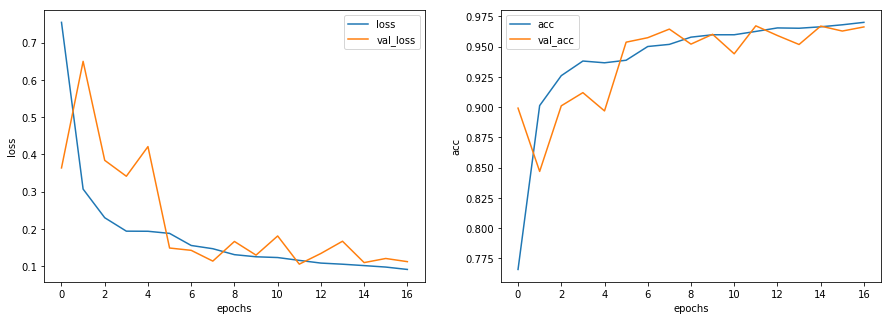

In [33]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.subplot(1,2,2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend(['acc', 'val_acc'])
plt.show()

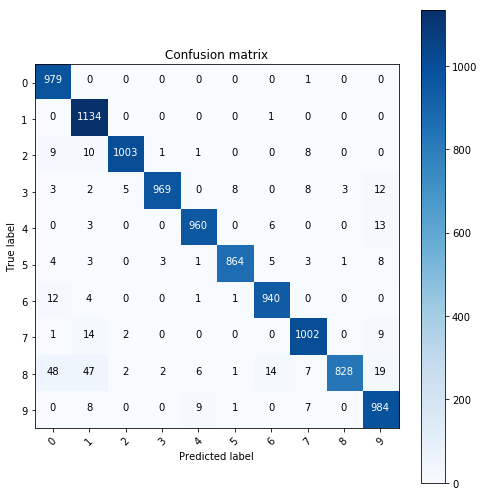

In [34]:
pred = np.argmax(model.predict(X_test, verbose = 0), axis=1)
cm = confusion_matrix(np.argmax(Y_test, axis=1), pred)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm, classes = [str(i) for i in range(Y_train.shape[1])])
plt.tight_layout()
plt.show()

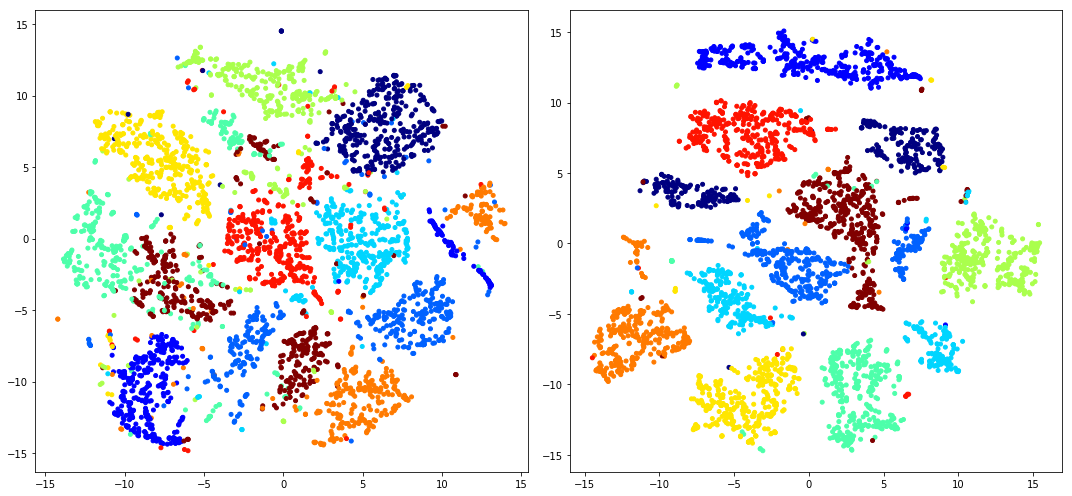

In [35]:
# Caution Below process takes long long time

# TSNE for original data
n_samples = 4000
rand_idx = np.random.randint(X_test.shape[0], size=[n_samples,])
tsne = TSNE()
tsne_output = tsne.fit_transform(np.reshape(X_test[rand_idx], (-1,X_test.shape[1] * X_test.shape[2])))

# TSNE for the second last layer's output
layer_func = K.function([model.layers[0].input, K.learning_phase()],[model.layers[-2].output])
layer_output = layer_func([X_test[rand_idx], 0])[0]
tsne = TSNE()
tsne_output2 = tsne.fit_transform(layer_output)

plt.figure(figsize=(15,7))

# plot original data
plt.subplot(1,2,1)
plt.scatter(tsne_output[:, 0], tsne_output[:,1], s = 4**2, c = np.argmax(Y_test, axis=1)[rand_idx], cmap='jet')

# plot the second last layer's output
plt.subplot(1,2,2)
plt.scatter(tsne_output2[:, 0], tsne_output2[:,1], s = 4**2, c = np.argmax(Y_test, axis=1)[rand_idx], cmap='jet')
plt.tight_layout()

plt.show()